In [1]:
import pandas as pd
import ete3
from collections import Counter
import ast

/n/home11/rkapoor/.conda/envs/rishabh/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Prep dataframes for impage production


In [42]:
df1=pd.read_csv("revised_cluster_info_v3.csv",index_col=0)

In [42]:
from Bio import Entrez
from ete3 import NCBITaxa

# Set your email here
Entrez.email = "your_email@example.com"

def get_taxid_from_protein(protein_id):
    """Retrieve taxid for a given protein ID."""
    handle = Entrez.esummary(db="protein", id=protein_id)
    record = Entrez.read(handle)
    taxid = record[0]['TaxId']
    return taxid

def get_taxonomy_lineage(taxid):
    """Retrieve the full lineage for a given taxid."""
    ncbi = NCBITaxa()
    lineage = ncbi.get_lineage(taxid)
  
    names = ncbi.get_taxid_translator(lineage)
    rank_names  = ncbi.get_rank(lineage)
    
    # Extract ranks and names
    rank_dict = {}
    for taxid in lineage:
        rank = rank_names[taxid]
        name = names[taxid]
        rank_dict[rank] = name
    
    return rank_dict

def main(protein_id):
    taxid = get_taxid_from_protein(protein_id)
    lineage = get_taxonomy_lineage(taxid)
    return taxid, lineage



In [36]:
prot_df=pd.DataFrame()
for index, row in df.iterrows():
    
    l=ast.literal_eval(row.secondary_chimeras)
    for seq in l:
        prot_df.loc[seq,["cluster"]]=index
        try:
            prot_df.loc[seq,"taxid"]=get_taxid_from_protein(seq.split("/")[0])
        except:
            time.sleep(5)
            print(seq)
            prot_df.loc[seq,"taxid"]=get_taxid_from_protein(seq.split("/")[0])
            


XP_024873093.1
XP_002031969.1
CAG7835345.1
XP_049881676.1


In [ ]:
cdf=pd.read_csv("chimeras_per_species_v2.csv",index_col=0)


In [4]:
r=cdf[cdf.refseq_annotation]

In [5]:
ac=[]
for index, row in r.iterrows():
    if "[" in str(row.Chimera_accessions):
        l=ast.literal_eval(row.Chimera_accessions)
        li=[x.split("(")[0] for x in l if "P_" in x]
        ac.extend(li)

In [6]:
prot_df=prot_df.loc[:,["cluster","taxid","lineage"]]

In [8]:
prot_df['in_search_set']=[x in list(ac) for x in prot_df.index]

In [9]:
for index, row in prot_df.iterrows():
    l=ast.literal_eval(row['lineage'])
    prot_df.loc[index,"tax_class"]=l['class']
    prot_df.loc[index,"tax_order"]=l['order']
    prot_df.loc[index,"tax_species"]=l['species']


In [77]:
for index, row in df.iterrows():
    df.loc[index,'taxid_set']=str(set(prot_df[prot_df.cluster==index].taxid))
    df.loc[index,'species_set']=str(set(prot_df[prot_df.cluster==index].tax_species))
    df.loc[index,'order_dist']=str(dict(Counter(prot_df[prot_df.cluster==index].tax_order)))
    df.loc[index,'class_dist']=str(dict(Counter(prot_df[prot_df.cluster==index].tax_class)))
    

In [14]:
prot_df=prot_df.loc[:,['in_search_set','cluster','taxid','tax_class','tax_order','tax_species','lineage']]
prot_df.to_csv('all_protein_tax_info.csv')

In [84]:
df.loc[:, ['species_set', 'taxid_set', 'n_species', 'tax_span', 'tax_span_rank',
       'order_dist', 'class_dist']].to_csv("tax_span_info.csv")

In [3]:
from pathlib import Path
import sys
import matplotlib.pyplot as plt

import matplotlib.font_manager
from matplotlib.font_manager import FontProperties

import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
fpath = Path(mpl.get_data_path(), "/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf")
from matplotlib.font_manager import FontProperties
from matplotlib import font_manager
plt.rcParams['figure.dpi'] = 300
font_path = "/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf"
font_manager.fontManager.addfont("/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf")
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
import numpy as np

## 2A. Chimeras per genome (for species w/ refseq genomes)


In [14]:
from Bio import Entrez
#written with chatgpt
def fetch_species_name_and_taxid(protein_accession):
    # Set email address (NCBI requires this)
    Entrez.email = "your_email@example.com"  # Replace with your email address

    # Fetch protein record from NCBI
    try:
        handle = Entrez.efetch(db="protein", id=protein_accession, rettype="gb", retmode="text")
        data = handle.read()
        handle.close()
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None, None

    # Find species name and taxid in the record
    import re
    try:
        # Regular expressions to find species name and taxid
        species_pattern = re.compile(r'/organism="([^"]+)"')
        taxid_pattern = re.compile(r'/db_xref="taxon:(\d+)"')
        
        species_match = species_pattern.search(data)
        taxid_match = taxid_pattern.search(data)
        
        species_name = species_match.group(1) if species_match else "Unknown"
        taxid = taxid_match.group(1) if taxid_match else "Unknown"
        
        return species_name
    except Exception as e:
        print(f"Error parsing data: {e}")
        return None, None



In [41]:
from Bio import Entrez

def get_taxid_from_species(species_name, email):
    """
    Fetches the TaxID for a given species name from NCBI.
    
    Parameters:
    - species_name: The name of the species.
    - email: Your email address (required by NCBI).
    
    Returns:
    - TaxID of the species or None if not found.
    """
    Entrez.email = email  # Always tell NCBI who you are
    
    try:
        # Search NCBI Taxonomy database for the species
        handle = Entrez.esearch(db="taxonomy", term=species_name, retmode="xml")
        record = Entrez.read(handle)
        handle.close()
        
        # Check if any results were found
        if record["Count"] == "0":
            print(f"No TaxID found for species: {species_name}")
            return None
        
        # Extract TaxID from the first result
        taxid = record["IdList"][0]
        return taxid

    except Exception as e:
        print(f"An error occurred: {e}")
        return None


In [24]:
chimeras_per_species={}
for index, row in df.iterrows():
    l=ast.literal_eval(row["secondary_chimeras"])
    for seq in l:
        sp=fetch_species_name_and_taxid(seq)
        if sp not in chimeras_per_species:
            chimeras_per_species[sp]=[]
     
        spl=chimeras_per_species[sp]
        spl.append(f"{seq}({index})")
        chimeras_per_species[sp]=spl
        


        

In [42]:
df_chimeras_per_species=pd.DataFrame()
for sp in chimeras_per_species:
    df_chimeras_per_species.loc[sp,"taxid"]=get_taxid_from_species(sp, "your.email@example.com")
    df_chimeras_per_species.loc[sp,"N_chimeras"]=len(chimeras_per_species[sp])
    df_chimeras_per_species.loc[sp,"Chimera_accessions"]=str(chimeras_per_species[sp])
    


In [120]:
df_chimeras_per_species['refseq_annotation']=[int(x) in list(acdf.taxid.astype(int)) for x in df_chimeras_per_species.taxid]

In [153]:
for index, row in df_chimeras_per_species.iterrows():
    l=ast.literal_eval(row["Chimera_accessions"])
    df_chimeras_per_species.loc[index,"N_refseq_chimeras"]=len([x for x in l if "P_" in x])

In [124]:
df_chimeras_per_species=df_chimeras_per_species.loc[:,['taxid', 'refseq_annotation','Chimera_accessions','N_chimeras','N_refseq_chimeras']]

In [192]:
for x in mi:
    name=acdf[acdf.taxid==x]["organism"].values[0].split("(")[0]
    df_chimeras_per_species.loc[name,["refseq_annotation","taxid","N_chimeras","N_refseq_chimeras"]]=[True,x,0,0]
    

In [201]:
df_chimeras_per_species.to_csv("chimeras_per_species_v2.csv")

In [13]:
##Load dataframe (after manual proofreading)
df_chimeras_per_species=pd.read_csv("data_upload_3_24_2025/Supplementary Table III_ HGT-chimeras per species - chimeras_per_species.tsv",sep="\t")

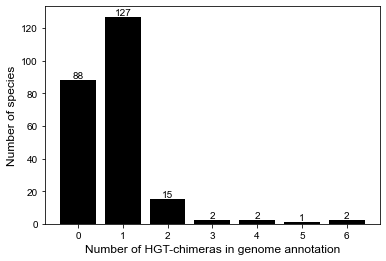

In [15]:
cm=Counter(list(df_chimeras_per_species[df_chimeras_per_species.in_search_set].N_refseq_chimeras))
bars = plt.bar([x for x in cm], [cm[x] for x in cm], color='black')

# Add labels over the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel("Number of HGT-chimeras in genome annotation", size=12)
plt.ylabel("Number of species", size=12)
plt.savefig("figures/Figure2/Fig2A.HGT_chimeras_per_genome.svg", format="svg")
plt.show()

In [18]:
r=df_chimeras_per_species[df_chimeras_per_species.in_search_set]

In [19]:
r[r.N_refseq_chimeras>0].shape[0]

149

## SI Figure 4. Chimeras per taxonomic class

In [38]:
acdf=pd.read_csv("data_upload_3_24_2025/Supplementary Table I_ genome_info.csv - chromosome_scaffold_level.tsv",sep="\t")
df=pd.read_csv("data_upload_3_24_2025/Supplementary Table IV_ chimera taxonomic distribution - tax_span_info_all_genomes.tsv",sep="\t")

In [57]:
df.to_csv("data_upload_3_24_2025/Supplementary Table IV_ chimera taxonomic distribution - tax_span_info_all_genomes.tsv",sep="\t")

In [34]:
taxid_class=dict()
for index, row in acdf.iterrows():
    taxid_class[row.taxid]=row["class"]

In [35]:
taxids=[]

In [36]:
import ast

In [47]:
for index, row in df.iterrows():
    taxids.extend(list([int(x) for x in ast.literal_eval(row["taxid_set"])]))
    

In [48]:
taxid_set=set(taxids)-set(["Hexanauplia"])

In [49]:
n_datasets=Counter(acdf["class"])

In [50]:
class_g1chimera={}
for x in set(acdf["class"]):
    class_g1chimera[x]=0
for x in taxid_set:
    if x in taxid_class:
        class_g1chimera[taxid_class[x]]+=1

In [52]:
n_chimera={}
for x in set(acdf["class"]):
    n_chimera[x]=0
for index, row in df.iterrows():
    tids=list([int(x) for x in ast.literal_eval(row["taxid_set"])])
    classes=set([taxid_class[x] for x in tids if x in taxid_class])
    for c in classes:
        n_chimera[c]+=1
        

In [53]:
class_data=pd.DataFrame(index=list(n_chimera.keys()))
for index, row in class_data.iterrows():
    class_data.loc[index,"N_datasets"]=n_datasets[index]
    class_data.loc[index,"N_datasets_with_at_least_1_chimera"]=class_g1chimera[index]
    class_data.loc[index,"N_chimeras"]=n_chimera[index]

In [54]:
class_data = class_data.rename(index={"Hexanauplia": "Copepoda"})

In [55]:
f=open("itol_pie_chart.txt","a")
for index, row in class_data.iterrows():
    no_chimera=int(row.N_datasets)-int(row.N_datasets_with_at_least_1_chimera)
    at_least_one=int(row.N_datasets_with_at_least_1_chimera)
    f.write(f"{index},-1,10,{no_chimera},{at_least_one}\n")
f.close()

In [56]:
class_data

,N_datasets,N_datasets_with_at_least_1_chimera,N_chimeras
Arachnida,13.0,4.0,5.0
Thecostraca,1.0,0.0,0.0
Insecta,207.0,134.0,26.0
Hexanauplia/Copepoda,2.0,1.0,1.0
Malacostraca,9.0,6.0,3.0
Branchiopoda,3.0,3.0,5.0
Collembola,1.0,1.0,6.0
Merostomata,1.0,0.0,0.0


## SI Figure 5 Taxonomic range of HGT-chimeras


In [27]:
df=pd.read_csv("data_upload_3_24_2025/Supplementary Table IV_ chimera taxonomic distribution - tax_span_info_all_genomes.tsv",sep="\t")

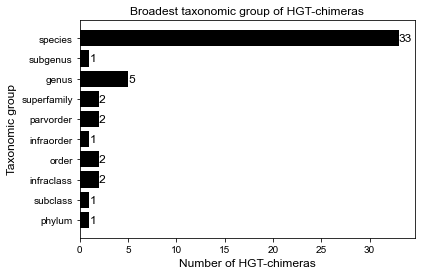

In [28]:
import matplotlib.pyplot as plt
from collections import Counter

# Assuming df is your DataFrame
counter = Counter(df.tax_span_rank)
values = ["phylum","subclass","infraclass","order","infraorder","parvorder","superfamily","genus","subgenus","species"]
counts = [counter[x] for x in values]

# Plot the histogram on the first subplot
plt.barh(values, counts, color='black')
plt.xlabel("Number of HGT-chimeras", fontsize=12)
plt.ylabel("Taxonomic group", fontsize=12)
plt.title("Broadest taxonomic group of HGT-chimeras",fontsize=12)
for index, value in enumerate(counts):
    plt.text(value, index, str(value), va='center', ha='left', fontsize=12, color='black')
plt.savefig("figures/Figure2/Fig2C.Broadest_taxonomic_group.png", format="png")
plt.show()

## Figure 2C: Broadest taxonomic group of HGT-chimeras

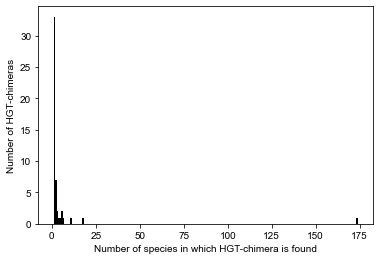

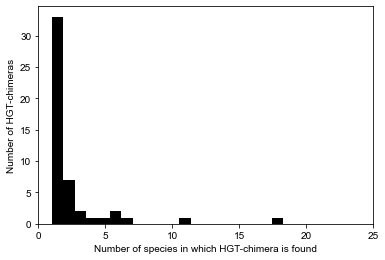

In [31]:
plt.hist(df.n_species,color="black",bins=200)
plt.xlabel("Number of species in which HGT-chimera is found")
plt.ylabel("Number of HGT-chimeras")
plt.show()
plt.hist(df.n_species,color="black",bins=200)
plt.xlim(0,25)
plt.xlabel("Number of species in which HGT-chimera is found")
plt.ylabel("Number of HGT-chimeras")
plt.savefig("figures/Figure2/Fig2D.species_per_chimera.svg", format="svg")
plt.show()